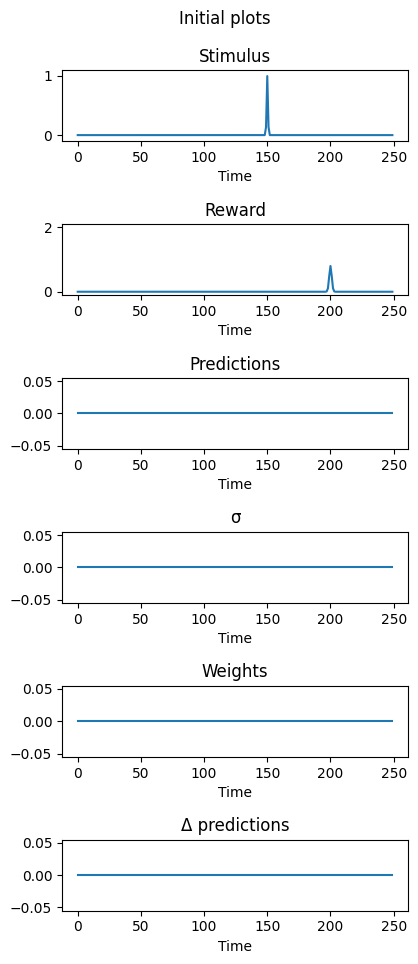

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

""" Supress future warnings for sns """
import warnings

""" Suppress FutureWarning messages """
warnings.simplefilter(action='ignore', category=FutureWarning)

""" Initialize values for the simulation """""
t_steps = 1

trial_time = 250
t_axes = np.arange(0, trial_time, t_steps)
predictions = np.zeros(len(t_axes))
delta = np.zeros(len(t_axes))
delta_predictions = np.zeros(len(t_axes))

tau = t_axes.copy()
weights = np.zeros(len(t_axes))
delta = np.zeros(len(t_axes))

n_trials = 250
n_axes = np.arange(0, n_trials, 1)
epsilon = 0.5

""" Create the stimulus function by intergrating a normal distribution"""
mu, sigma = 0, 0.5 # mean and standard deviation
x = np.arange(mu - 10 * sigma, mu + 10*sigma, t_steps)
scale = 1.25
norm_dist = stats.norm.pdf(x, mu, sigma) * scale

stimulus = np.zeros(len(t_axes))
t_stimulus = 150
t_stimulus_1 = np.where(t_axes == (t_stimulus - 10 * sigma))[0][0]
t_stimulus_2 = np.where(t_axes == (t_stimulus + 10 * sigma))[0][0]
stimulus[t_stimulus_1 : t_stimulus_2] = norm_dist 

""" Create the reward function by intergrating a normal distribution"""
mu, sigma = 0, 1 # mean and standard deviation
x = np.arange(mu - 10*sigma, mu + 10*sigma, t_steps)
scale = 2
norm_dist = stats.norm.pdf(x, mu, sigma) * scale

reward = np.zeros(len(t_axes))
t_reward = 200
t_reward_1 = np.where(t_axes == (t_reward - 10 * sigma))[0][0]
t_reward_2 = np.where(t_axes == (t_reward + 10 * sigma))[0][0]
reward[t_reward_1 : t_reward_2] = norm_dist

""" Initilaize results matrices """""

res_delta = np.zeros((n_trials, len(t_axes)))
res_weights = np.zeros((n_trials, len(t_axes)))
res_predictions = np.zeros((n_trials, len(t_axes)))
res_delta_predictions = np.zeros((n_trials, len(t_axes)))


""" Plot the different variables in suplots """
""" Plot the different variables in suplots """
fig, axs = plt.subplots(6, 1, figsize=(5, 10))

plt.tight_layout(pad=4.0)
fig.suptitle('Initial plots')
fig.subplots_adjust(top=0.92)

g1 = sns.lineplot(x = t_axes, y = stimulus, ax = axs[0])
g1.set(ylim=(-0.1, 1.1), title = 'Stimulus', xlabel = 'Time')
g2 = sns.lineplot(x = t_axes, y = reward, ax = axs[1])
g2.set(ylim=(-0.1, 2.1), title = 'Reward', xlabel = 'Time')
g3 = sns.lineplot(x = t_axes, y = predictions, ax = axs[2])
g3.set(title = 'Predictions', xlabel = 'Time')
g4 = sns.lineplot(x = t_axes, y = delta, ax = axs[3])
g4.set(title = '\u03C3', xlabel = 'Time')
g5 = sns.lineplot(x = t_axes, y = weights, ax = axs[4])
g5.set(title = 'Weights', xlabel = 'Time')
g6 = sns.lineplot(x = t_axes, y = delta_predictions, ax = axs[5])
g6.set(title = '\u0394 predictions', xlabel = 'Time')

plt.savefig('Initial_plots_smaller_timing.jpg')    
    

In [2]:
""" Update the weights, keep the old weights """
def update_weights(weights, idx_tau, epsilon, delta, idx_t, stimulus):
    weights[idx_tau]+= epsilon * delta[idx_t] * stimulus[idx_t - idx_tau]
    return weights

""" Make a discrete convolution function to calculate the predictions """
def make_predictions(predictions,weights, idx_t, stimulus):
    for idx_tau in range(idx_t):
        predictions[idx_t] += weights[idx_tau] * stimulus[idx_t - idx_tau]

    return predictions

def simulation(n_trials, t_axes, weights, epsilon, delta, predictions, stimulus, reward):
    """ Loop over the number of trials"""
    for n in range(n_trials):   
        """ For every trial reset delta and predictions, but keep weights """
        delta = np.zeros(len(t_axes))
        predictions = np.zeros(len(t_axes))
        
        """ First make predictions, then calculate delta, then update weights, 
            Since for calculating delta you need the predictions and for calulating 
            the weights you need the delta"""
        for idx_t,t in enumerate(t_axes):
            predictions = make_predictions(predictions,weights, idx_t, stimulus)
        
        """ Calculate the deltas and delta predictions"""
        for idx_t,t in enumerate(t_axes):
            """ If we are at the last time point we can't make a prediction for the,
                next time point, so set delta as reward and delta predictions as 0 """
            if t != t_axes[-1]:
                delta[idx_t] = reward[idx_t] + predictions[idx_t+1] - predictions[idx_t]
                delta_predictions = predictions[idx_t+1] - predictions[idx_t]
            elif t == t_axes[-1]:
                delta[idx_t] = reward[idx_t]
                delta_predictions = 0
        """ Calculate the new weights, keep the old weights. Since reading and 
            writing to the same array at the same time is not possible in python """
        for idx_t,t in enumerate(t_axes): 
            for idx_tau in range(idx_t):
                old_weights = weights.copy()
                weights = update_weights(old_weights, idx_tau, epsilon, delta, idx_t, stimulus)
    
        """ Store the results """
        res_delta[n, :] = delta
        res_weights[n, :] = weights
        res_predictions[n, :] = predictions
        res_delta_predictions[n, :] = delta_predictions
    return res_delta, res_weights, res_predictions, res_delta_predictions

simulation_res = simulation(n_trials, t_axes, weights, epsilon, delta, predictions, stimulus, reward)
            

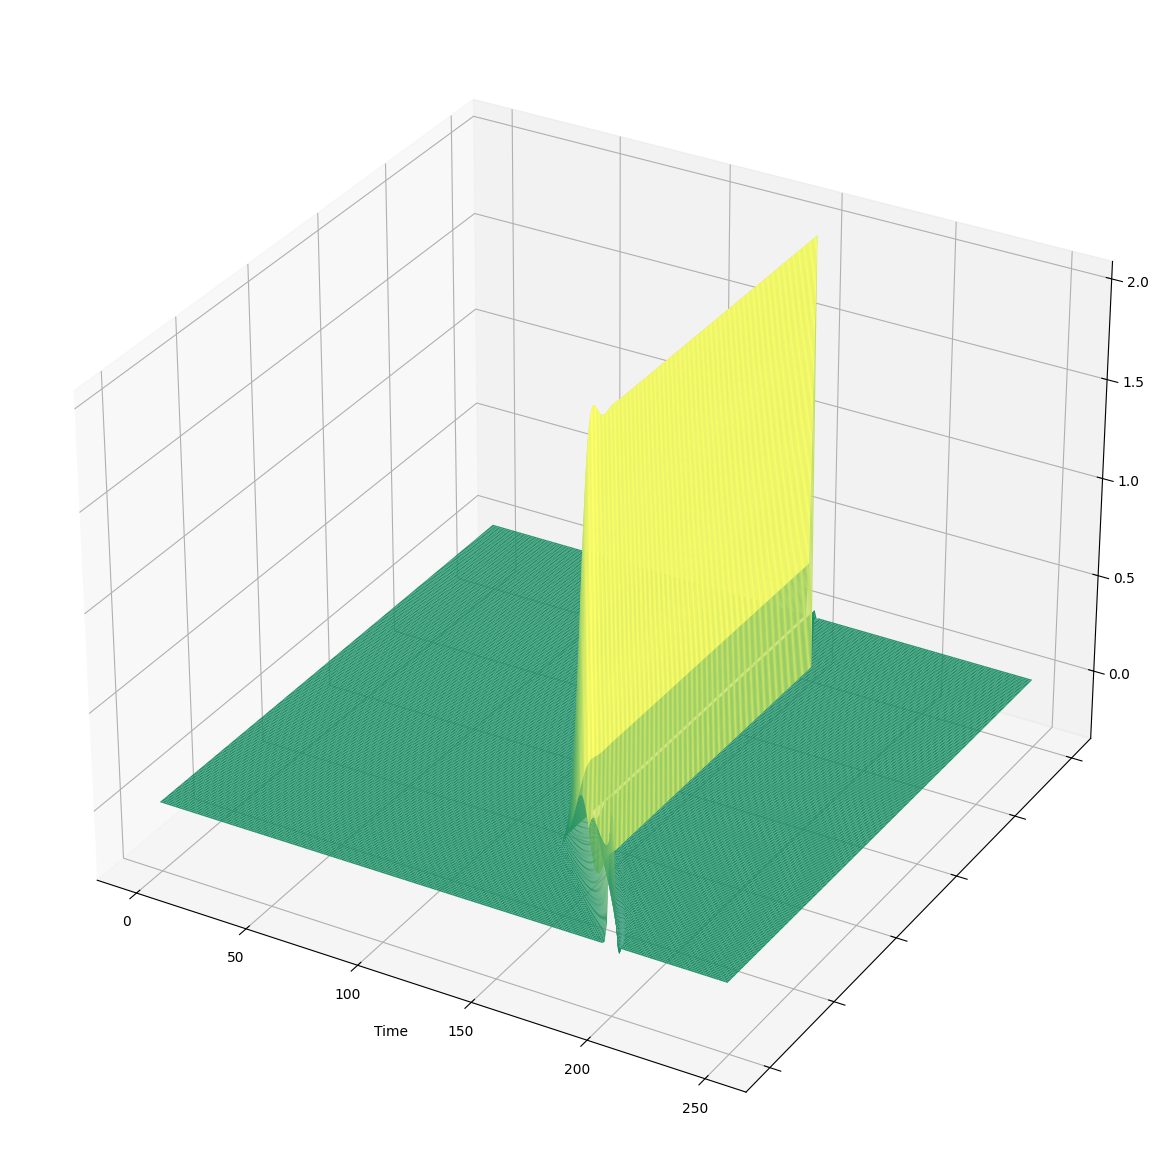

In [3]:
""" Create 3d matplotlib plot for trials, delta, weights"""

import matplotlib.pyplot as plt
import numpy as np

""" Overhand the results """
res_delta = simulation_res[0]
res_weights = simulation_res[1]
res_predictions = simulation_res[2]
res_delta_predictions = simulation_res[3]

""" Plot the weights in a 3d plot """
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection='3d')

X = t_axes
Y = n_axes
X, Y = np.meshgrid(X, Y)
Z = res_delta


surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                       antialiased=True, cmap='summer')
ax.yaxis.set_ticklabels([])
ax.xaxis.set_label_text('Time')
""" Turn the 3d plot """
ax.view_init(30, -60) 

plt.savefig('Time_delta_smaller_timing.jpg')

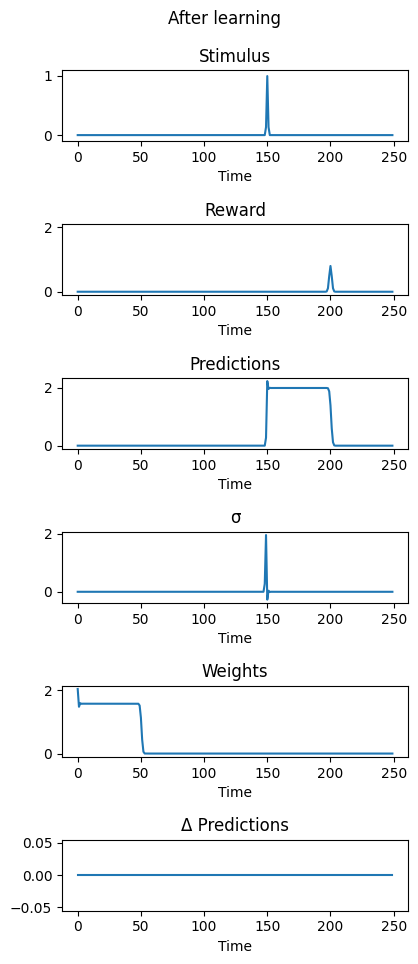

In [4]:
""" Plot the variables for the last iteration"""
fig, axs = plt.subplots(6, 1, figsize=(5, 10))
# padding between subplots
plt.tight_layout(pad=4.0)
fig.suptitle('After learning')
fig.subplots_adjust(top=0.92)

# seaborn lineplot
g1 = sns.lineplot(x = t_axes, y = stimulus, ax = axs[0])
g1.set(ylim=(-0.1, 1.1), title = 'Stimulus', xlabel = 'Time')
g2 = sns.lineplot(x = t_axes, y = reward, ax = axs[1])
g2.set(ylim=(-0.1, 2.1), title = 'Reward', xlabel = 'Time')
g3 = sns.lineplot(x = t_axes, y = res_predictions[-1,:], ax = axs[2])
g3.set(title = 'Predictions', xlabel = 'Time')
g4 = sns.lineplot(x = t_axes, y = res_delta[-1,:], ax = axs[3])
g4.set(title = '\u03C3', xlabel = 'Time')
g5 = sns.lineplot(x = t_axes, y = res_weights[-1,:], ax = axs[4])
g5.set(title = 'Weights', xlabel = 'Time')
g6 = sns.lineplot(x = t_axes, y = res_delta_predictions[-1,:], ax = axs[5])
g6.set(title = '\u0394 Predictions', xlabel = 'Time')

plt.savefig('Timepoint_0_values_smaller_timing.jpg')

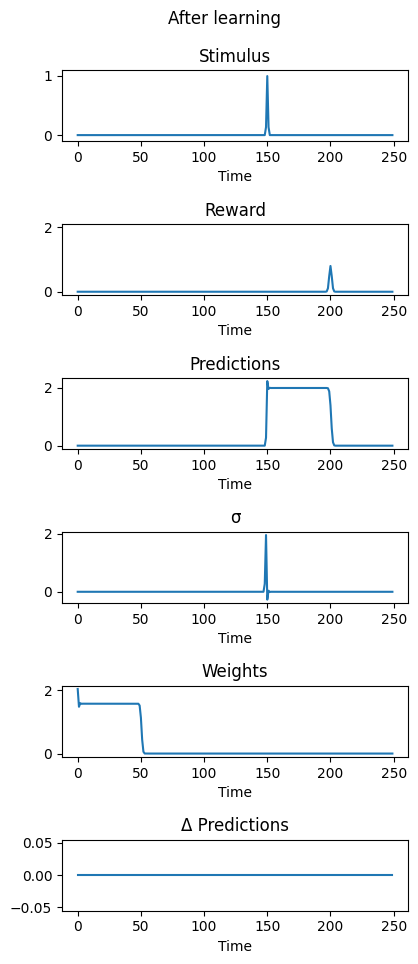

In [5]:
# seaborn lineplot
fig, axs = plt.subplots(6, 1, figsize=(5, 10))
# padding between subplots
plt.tight_layout(pad=4.0)
fig.suptitle('After learning')
fig.subplots_adjust(top=0.92)

# seaborn lineplot
g1 = sns.lineplot(x = t_axes, y = stimulus, ax = axs[0])
g1.set(ylim=(-0.1, 1.1), title = 'Stimulus', xlabel = 'Time')
g2 = sns.lineplot(x = t_axes, y = reward, ax = axs[1])
g2.set(ylim=(-0.1, 2.1), title = 'Reward', xlabel = 'Time')
g3 = sns.lineplot(x = t_axes, y = res_predictions[-1,:], ax = axs[2])
g3.set(title = 'Predictions', xlabel = 'Time')
g4 = sns.lineplot(x = t_axes, y = res_delta[-1,:], ax = axs[3])
g4.set(title = '\u03C3', xlabel = 'Time')
g5 = sns.lineplot(x = t_axes, y = res_weights[-1,:], ax = axs[4])
g5.set(title = 'Weights', xlabel = 'Time')
g6 = sns.lineplot(x = t_axes, y = res_delta_predictions[-1,:], ax = axs[5])
g6.set(title = '\u0394 Predictions', xlabel = 'Time')

plt.savefig('Timepoint_-1_values_smaller_timing.jpg')